In [1]:
!pip install python-dotenv catboost optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00


In [78]:
import json
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import psycopg2
from itertools import chain
import ast
from collections import Counter
import math

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [16]:
pd.set_option('display.max_columns', None)

In [3]:
load_dotenv()

db_ip = os.getenv("DB_IP")
db_port = int(os.getenv("DB_PORT"))
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")

Проверка подключения

In [4]:
try:
    connection = psycopg2.connect(
        host=db_ip,
        port=db_port,
        database=db_name,
        user=db_user,
        password=db_password
    )
    print("Успешное подключение к базе данных!")
except Exception as e:
    print(f"Ошибка подключения: {e}")
finally:
    if 'connection' in locals() and connection:
        connection.close()

Успешное подключение к базе данных!


In [5]:
connection = psycopg2.connect(
        host=db_ip,
        port=db_port,
        database=db_name,
        user=db_user,
        password=db_password
    )
connection.autocommit = True
cursor = connection.cursor()

#### Внутри бд

In [6]:
cursor.execute("SELECT datname FROM pg_database WHERE datistemplate = false;")
databases = cursor.fetchall()

print("Список баз данных:")
for db in databases:
    print(db[0])

Список баз данных:
postgres
admin
tg_channels


In [7]:
cursor.execute("SELECT schema_name FROM information_schema.schemata;")
schemas = cursor.fetchall()

print("Список схем:")
for schema in schemas:
    print(schema[0])

Список схем:
public
information_schema
pg_catalog
embeddings
ml_house
parse


In [8]:
def get_columns_for_table(cursor, schema_name, table_name):
    """Получает список столбцов для заданной таблицы."""
    cursor.execute(
        "SELECT column_name FROM information_schema.columns WHERE table_schema = %s AND table_name = %s;",
        (schema_name, table_name)
    )
    columns = cursor.fetchall()
    return [col[0] for col in columns]



def get_table_names_and_columns(cursor, schema_name):
    """Получает список таблиц и их столбцов в заданной схеме."""

    cursor.execute(
        "SELECT table_name FROM information_schema.tables WHERE table_schema = %s;",
        (schema_name,)
    )
    tables = cursor.fetchall()
    table_data = {}

    for (table,) in tables:
        print(f"Таблица: {table}")
        table_data[table] = get_columns_for_table(cursor, schema_name, table)
    return table_data


In [9]:
get_table_names_and_columns(cursor, 'parse')

Таблица: runs
Таблица: posts_metadata
Таблица: posts_flags
Таблица: posts_metrics
Таблица: posts_content
Таблица: forwards
Таблица: peers
Таблица: channels
Таблица: similars


{'runs': ['id',
  'channel_id',
  'from_date',
  'scrape_date',
  'posts_scraped',
  'exec_time'],
 'posts_metadata': ['id',
  'channel_id',
  'post_id',
  'group_id',
  'post_date',
  'scrape_date'],
 'posts_flags': ['id',
  'is_post',
  'silent',
  'noforwards',
  'pinned',
  'fwd_from_flag',
  'photo',
  'document',
  'web',
  'audio',
  'voice',
  'video',
  'gif'],
 'posts_metrics': ['id',
  'views',
  'forwards',
  'comments',
  'paid_reactions',
  'standard_reactions',
  'custom_reactions'],
 'posts_content': ['id',
  'raw_text',
  'urls',
  'geo',
  'poll',
  'via_bot_id',
  'via_business_bot_id'],
 'forwards': ['id', 'from_ch_id', 'from_post_id'],
 'peers': ['id', 'scraper_id', 'channel_name', 'channel_id', 'access_hash'],
 'channels': ['id',
  'name',
  'title',
  'participants',
  'last_pinned_msg_id',
  'about'],
 'similars': ['id',
  'base_channel_id',
  'similar_channel_id',
  'similar_channel_name',
  'similar_channel_title']}

In [10]:
dict_table_field = get_table_names_and_columns(cursor, 'ml_house')

Таблица: ad_basis
Таблица: metrics_agg
Таблица: final_basis
Таблица: final_basis_with_metrics
Таблица: final_basis_with_metrics_v2
Таблица: basis_with_metrics


In [11]:
dict_table_field['final_basis_with_metrics']

['id',
 'raw_text',
 'urls',
 'geo',
 'poll',
 'via_bot_id',
 'via_business_bot_id',
 'cnt_urls',
 'target_flag1',
 'target_flag2',
 'target_flag3',
 'target_flag4',
 'target_flag5',
 'target_flag6',
 'target_flag7',
 'target_flag8',
 'target_flag9',
 'target_flag10',
 'is_post',
 'silent',
 'noforwards',
 'pinned',
 'fwd_from_flag',
 'photo',
 'document',
 'web',
 'audio',
 'voice',
 'video',
 'gif',
 'channel_id',
 'post_date',
 'id_channels',
 'participants',
 'about',
 'views',
 'forwards',
 'comments',
 'paid_reactions',
 'standard_reactions',
 'custom_reactions',
 'sum_standard_reactions',
 'sum_custom_reactions',
 'total_sum_reactions',
 'good_finger',
 'heart',
 'fire',
 'fun',
 'bad_finger',
 'total_activites',
 'relative_total_sum_reactions',
 'relative_paid_reactions',
 'relative_good_finger',
 'relative_sum_custom_reactions',
 'relative_forwards',
 'relative_heart',
 'relative_comments',
 'relative_fun',
 'relative_sum_standard_reactions',
 'relative_bad_finger',
 'relative

In [12]:
cursor.execute(
    "SELECT table_name FROM information_schema.tables WHERE table_schema = %s;",
    ('parse',)
)
tables = cursor.fetchall()
for (table,) in tables:
    print(table)
    # Чтение данных из таблицы
    cursor.execute("SELECT * FROM parse.{} LIMIT 3;".format(table))
    rows = cursor.fetchall()

    for row in rows:
        print(row)
    print('------------------------------')

runs
(1, 1443540902, datetime.datetime(2023, 12, 31, 21, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2024, 11, 27, 22, 14, 33, 785000, tzinfo=datetime.timezone.utc), 124, 2.4962127208709717)
(2, 1299300076, datetime.datetime(2023, 12, 31, 21, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2024, 11, 27, 22, 14, 36, 293000, tzinfo=datetime.timezone.utc), 166, 2.4739153385162354)
(3, 1595748703, datetime.datetime(2023, 12, 31, 21, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2024, 11, 27, 22, 14, 38, 917000, tzinfo=datetime.timezone.utc), 1267, 13.70917558670044)
------------------------------
posts_metadata
(20163752, 1235821477, 1036, 13761357683263962, datetime.datetime(2024, 7, 5, 8, 55, 10, tzinfo=datetime.timezone.utc), datetime.datetime(2024, 12, 6, 12, 53, 53, 593971, tzinfo=datetime.timezone.utc))
(20163753, 1235821477, 1035, None, datetime.datetime(2024, 7, 4, 15, 52, 28, tzinfo=datetime.timezone.utc), datetime.datetime(2024, 12, 6, 12, 53, 53, 593995, tzinfo

### Достаем уже нужные данные

In [13]:
cursor.execute("SELECT * FROM ml_house.final_basis_with_metrics c  \
      where c.raw_text like '%#реклама%' or c.raw_text like '%#ad %' or c.raw_text like '%#ad' \
      or c.raw_text like '%#Ad %' or c.raw_text like '%#Ad'")
rows = cursor.fetchall()
len(rows)

5989

In [34]:
df = pd.DataFrame(rows, columns=dict_table_field['final_basis_with_metrics'])
df.head(4)

,id,raw_text,urls,geo,poll,via_bot_id,via_business_bot_id,cnt_urls,target_flag1,target_flag2,target_flag3,target_flag4,target_flag5,target_flag6,target_flag7,target_flag8,target_flag9,target_flag10,is_post,silent,noforwards,pinned,fwd_from_flag,photo,document,web,audio,voice,video,gif,channel_id,post_date,id_channels,participants,about,views,forwards,comments,paid_reactions,standard_reactions,custom_reactions,sum_standard_reactions,sum_custom_reactions,total_sum_reactions,good_finger,heart,fire,fun,bad_finger,total_activites,relative_total_sum_reactions,relative_paid_reactions,relative_good_finger,relative_sum_custom_reactions,relative_forwards,relative_heart,relative_comments,relative_fun,relative_sum_standard_reactions,relative_bad_finger,relative_fire,relative_total_activites,relative_,views_avg_last_50,forwards_avg_last_50,comments_avg_last_50,paid_reactions_avg_last_50,sum_standard_reactions_avg_last_50,sum_custom_reactions_avg_last_50,total_sum_reactions_avg_last_50,good_finger_avg_last_50,heart_avg_last_50,fire_avg_last_50,fun_avg_last_50,bad_finger_avg_last_50,total_activites_avg_last_50,relative_forwards_avg_last_50,relative_comments_avg_last_50,relative_paid_reactions_avg_last_50,relative_sum_standard_reactions_avg_last_50,relative_sum_custom_reactions_avg_last_50,relative_total_sum_reactions_avg_last_50,relative_good_finger_avg_last_50,relative_heart_avg_last_50,relative_fire_avg_last_50,relative_fun_avg_last_50,relative_bad_finger_avg_last_50,relative_total_activites_avg_last_50
0,8846882,#реклама Реальный и доступный способ переехать...,"{https://t.me/eduvienna/2747,https://t.me/eduv...",None,None,None,None,2,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,True,False,False,False,False,False,False,1005031786,2024-02-19 15:07:41+00:00,1005031786,469666,"Прислать новость, разместить рекламу, позвонит...",102430.0,917.0,26.0,0,"{'👍': 564, '❤': 96, '🤡': 32, '👎': 17, '🤮': 12,...",{},741,0,741,564,96,9,0,17,1684.0,0.007234,0.0,0.005506,0.0,0.008952,0.000937,0.000254,0.000000,0.007234,0.000166,0.000088,0.016440,128.982613,5719747.0,18733.0,3647.0,0.0,132265.0,309.0,132574.0,8836.0,27466.0,284.0,151.0,342.0,154954.0,0.003275,0.000638,0.0,0.023124,0.000054,0.023178,0.001545,0.004802,0.000050,0.000026,0.000060,0.027091
1,8840435,#реклама\n\nБудьте в курсе новостей Израиля — ...,{https://t.me/doc_inside/266},None,None,None,None,1,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,1005031786,2024-05-24 13:40:29+00:00,1005031786,469666,"Прислать новость, разместить рекламу, позвонит...",65186.0,10.0,4.0,0,"{'🤡': 115, '❤': 66, '👍': 48, '🤮': 30, '🤔': 11,...",{},276,0,276,48,66,2,0,0,290.0,0.004234,0.0,0.000736,0.0,0.000153,0.001012,0.000061,0.000000,0.004234,0.000000,0.000031,0.004449,202.622358,3465927.0,6543.0,1254.0,0.0,30112.0,0.0,30112.0,3097.0,1796.0,31.0,1816.0,321.0,37909.0,0.001888,0.000362,0.0,0.008688,0.000000,0.008688,0.000894,0.000518,0.000009,0.000524,0.000093,0.010938
2,8840331,Batumi Investment уже десять лет работает на р...,"{https://www.youtube.com/watch?v=6Bk5yDL4rSs,\...",None,None,None,None,2,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,True,False,False,False,False,False,False,1005031786,2024-05-28 09:52:35+00:00,1005031786,469666,"Прислать новость, разместить рекламу, позвонит...",71757.0,46.0,4.0,0,"{'👍': 245, '❤': 61, '👎': 44, '🤡': 43, '🤮': 29,...",{},438,0,438,245,61,0,8,44,488.0,0.006104,0.0,0.003414,0.0,0.000641,0.000850,0.000056,0.000111,0.006104,0.000613,0.000000,0.006801,184.066279,3634242.0,8372.0,1047.0,0.0,37911.0,74.0,37985.0,5909.0,4018.0,448.0,2707.0,183.0,47404.0,0.002304,0.000288,0.0,0.010432,0.000020,0.010452,0.001626,0.001106,0.000123,0.000745,0.000050,0.013044
3,8839950,"Все, что вы хотели знать про репатриацию в Изр...","{https://t.me/+Sby9SZy-O1ueFlvF,https://t.me/+...",None,None,None,None,2,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,True,False,False,False,False,False,False,1005031786,2024-06-10 14:24:38+00:00,1005031786,469666,"Прислат

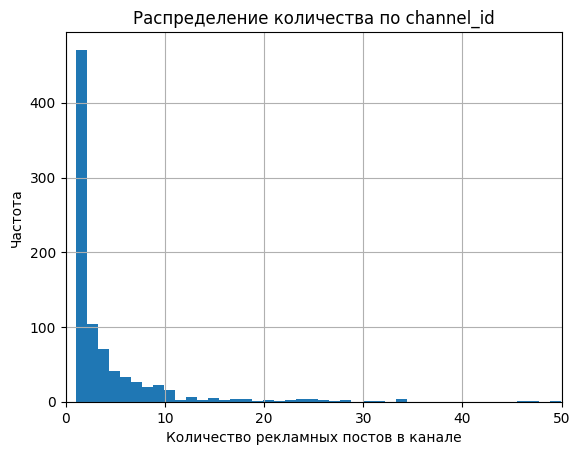

In [63]:
df.groupby('channel_id')['id'].count().hist(bins=400)

plt.xlim(0, 50)

plt.title('Распределение количества по channel_id')
plt.xlabel('Количество рекламных постов в канале')
plt.ylabel('Частота')

plt.show()

In [35]:
df['dict'] = df['standard_reactions'].apply(lambda x: ast.literal_eval(x))
all_keys = set(chain.from_iterable(df['dict'].apply(lambda x: x.keys())))

reaction_counts = Counter()
for reactions in df['dict']:
    reaction_counts.update(reactions)

print("Общее количество реакций:", reaction_counts)

Общее количество реакций: Counter({'👍': 405543, '❤': 194783, '🔥': 104476, '👎': 65953, '🤣': 40716, '🤮': 16894, '😁': 16886, '🤔': 16785, '🤡': 13453, '❤\u200d🔥': 9882, '🎉': 7854, '👌': 7219, '😍': 7206, '🤯': 6446, '🍓': 5692, '🤗': 5540, '😢': 5418, '🐳': 5344, '💔': 5217, '👀': 4530, '🍌': 4399, '🥰': 3794, '🤩': 3501, '👏': 3325, '🍾': 3007, '🤬': 2214, '🦄': 1951, '💩': 1651, '💯': 1518, '💘': 1383, '🌭': 1190, '🎄': 1167, '⚡': 1161, '😱': 1028, '🏆': 941, '🎅': 853, '☃': 817, '🆒': 783, '💅': 686, '✍': 672, '💊': 576, '🤝': 549, '🤪': 536, '🗿': 533, '🥱': 530, '🥴': 439, '👻': 373, '🙈': 311, '😇': 302, '🌚': 289, '😡': 266, '😭': 246, '💋': 185, '😴': 175, '🕊': 170, '🤨': 158, '🖕': 153, '🤷\u200d♂': 151, '🙏': 139, '😐': 119, '😘': 92, '😈': 90, '🤷\u200d♀': 88, '😨': 77, '🫡': 76, '👾': 68, '😎': 68, '🤓': 63, '🎃': 37, '🙉': 37, '👨\u200d💻': 25, '🙊': 23, '🤷': 11})


In [30]:
good_reactions = ['👍', '❤', '🔥', '🤣', '😁', '❤\u200d🔥', '🎉', '😍', '🥰', '👏', '💯', '😎', '😇', '🍾', '🤝']
bad_reactions = ['👎', '🤮', '🤡', '🤯', '🤬', '💩', '😱', '🥴', '💊', '🥱', '🗿', '😡', '🖕', '🤔']

In [36]:
# Функция для подсчёта доли реакций
def calculate_reaction_shares(reactions, good_reactions, bad_reactions):
    total_reactions = sum(reactions.values())  # Общее количество реакций
    good_count = sum(count for reaction, count in reactions.items() if reaction in good_reactions)
    bad_count = sum(count for reaction, count in reactions.items() if reaction in bad_reactions)

    good_share = good_count / total_reactions if total_reactions > 0 else 0
    bad_share = bad_count / total_reactions if total_reactions > 0 else 0

    return good_share, bad_share

df[['good_share', 'bad_share']] = df['dict'].apply(
    lambda x: pd.Series(calculate_reaction_shares(x, good_reactions, bad_reactions))
)

In [38]:
df[['dict', 'good_share', 'bad_share']].iloc[35:45]

,dict,good_share,bad_share
35,"{'❤‍🔥': 143, '👎': 74, '👍': 64, '❤': 27, '😁': 4...",0.757962,0.235669
36,"{'👍': 159, '👎': 13, '❤': 11, '❤‍🔥': 3, '😁': 2,...",0.921053,0.068421
37,"{'❤': 169, '👍': 107, '🤡': 50, '👎': 12, '🤮': 12...",0.775068,0.224932
38,"{'🤮': 6677, '👎': 2534, '👍': 157, '😁': 53, '🤔':...",0.022963,0.976614
39,"{'👍': 289, '❤': 85, '🤡': 31, '🕊': 12, '🙏': 9, ...",0.863741,0.087760
40,"{'👍': 114, '🤮': 42, '❤': 25, '🤡': 10, '🤔': 8, ...",0.681373,0.318627
41,"{'🥱': 163, '😘': 61, '🤔': 39, '🤣': 20, '🥴': 11}",0.068027,0.724490
42,{'❤': 4},1.000000,0.000000
43,{},0.000000,0.000000
44,{'👍': 1},1.000000,0.000000


Новые фичи на основе 5 предыдущих рекламных постов в канале, не включая данные текущего поста

In [42]:
def calculate_rolling_means(df, columns, group_by_col='channel_id',  window=5, min_periods=1):
    for column in columns:
        new_col_name = f"{column}_avg_{window}"
        df[new_col_name] = (
            df.groupby(group_by_col)[column]
            .apply(lambda x: x.shift(1).rolling(window=window, min_periods=min_periods).mean())
            .reset_index(level=0, drop=True)
            .fillna(0)
        )
    return df


In [43]:
df.sort_values(by=['channel_id', 'post_date'], inplace=True)

df = calculate_rolling_means(df, ['good_share', 'bad_share', 'total_sum_reactions', 'views', 'forwards', 'comments'])

In [44]:
df.head(5)

,id,raw_text,urls,geo,poll,via_bot_id,via_business_bot_id,cnt_urls,target_flag1,target_flag2,target_flag3,target_flag4,target_flag5,target_flag6,target_flag7,target_flag8,target_flag9,target_flag10,is_post,silent,noforwards,pinned,fwd_from_flag,photo,document,web,audio,voice,video,gif,channel_id,post_date,id_channels,participants,about,views,forwards,comments,paid_reactions,standard_reactions,custom_reactions,sum_standard_reactions,sum_custom_reactions,total_sum_reactions,good_finger,heart,fire,fun,bad_finger,total_activites,relative_total_sum_reactions,relative_paid_reactions,relative_good_finger,relative_sum_custom_reactions,relative_forwards,relative_heart,relative_comments,relative_fun,relative_sum_standard_reactions,relative_bad_finger,relative_fire,relative_total_activites,relative_,views_avg_last_50,forwards_avg_last_50,comments_avg_last_50,paid_reactions_avg_last_50,sum_standard_reactions_avg_last_50,sum_custom_reactions_avg_last_50,total_sum_reactions_avg_last_50,good_finger_avg_last_50,heart_avg_last_50,fire_avg_last_50,fun_avg_last_50,bad_finger_avg_last_50,total_activites_avg_last_50,relative_forwards_avg_last_50,relative_comments_avg_last_50,relative_paid_reactions_avg_last_50,relative_sum_standard_reactions_avg_last_50,relative_sum_custom_reactions_avg_last_50,relative_total_sum_reactions_avg_last_50,relative_good_finger_avg_last_50,relative_heart_avg_last_50,relative_fire_avg_last_50,relative_fun_avg_last_50,relative_bad_finger_avg_last_50,relative_total_activites_avg_last_50,dict,good_share,bad_share,good_share_avg_5,bad_share_avg_5,total_sum_reactions_avg_5,views_avg_5,forwards_avg_5,comments_avg_5
5971,9257507,#менеджер #закуп #реклама\n\nЗарабатывай от 12...,{https://forms.gle/1aTrtAcFrdPRJEK59},None,None,None,None,1,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,1000735083,2024-01-28 10:02:48+00:00,1000735083,52671,"Канал проекта ""Dистанция"". Публикуем вакансии ...",1722.0,0.0,0.0,0,{'👍': 4},{},4,0,4,4,0,0,0,0,4.0,0.002323,0.0,0.002323,0.0,0.0,0.000000,0.0,0.0,0.002323,0.0,0.0,0.002323,4419.191057,85863.0,0.0,3.0,0.0,199.0,0.0,199.0,85.0,41.0,13.0,0.0,0.0,202.0,0.0,0.000035,0.0,0.002318,0.0,0.002318,0.000990,0.000478,0.000151,0.0,0.0,0.002353,{'👍': 4},1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
5972,9256935,#ищу #реклама #закупрекламы\n\nВ команду Марии...,{ttps://forms.gle/pBScR6MHodRkiJpR8},None,None,None,None,1,0,0,1,0,0,0,0,0,0,0,True,True,False,False,False,False,False,False,False,False,False,False,1000735083,2024-02-11 10:03:05+00:00,1000735083,52671,"Канал проекта ""Dистанция"". Публикуем вакансии ...",1970.0,0.0,0.0,0,"{'🤝': 2, '❤': 1}",{},3,0,3,0,1,0,0,0,3.0,0.001523,0.0,0.000000,0.0,0.0,0.000508,0.0,0.0,0.001523,0.0,0.0,0.001523,3862.637563,87228.0,0.0,1.0,0.0,178.0,0.0,178.0,58.0,25.0,12.0,0.0,0.0,179.0,0.0,0.000011,0.0,0.002041,0.0,0.002041,0.000665,0.000287,0.000138,0.0,0.0,0.002052,"{'🤝': 2, '❤': 1}",1.0,0.0,1.0,0.0,4.000000,1722.000000,0.0,0.0
5973,9255651,#вакансия #менеджер #реклама #Wildberries \nМы...,{https://forms.gle/Mx5c8ePW4ND5EBHQ9},None,None,None,None,1,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,1000735083,2024-03-20 16:29:17+00:00,1000735083,52671,"Канал проекта ""Dистанция"". Публикуем вакансии ...",2150.0,0.0,0.0,0,"{'👍': 2, '❤': 1}",{},3,0,3,2,1,0,0,0,3.0,0.001395,0.0,0.000930,0.0,0.0,0.000465,0.0,0.0,0.001395,0.0,0.0,0.001395,3538.668372,87067.0,0.0,2.0,0.0,131.0,0.0,131.0,38.0,40.0,5.0,0.0,0.0,133.0,0.0,0.000023,0.0,0.001505,0.0,0.001505,0.000436,0.000459,0.000057,0.0,0.0,0.001528,"{'👍': 2, '❤': 1}",1.0,0.0,1.0,0.0,3.500000,1846.000000,0.0,0.0
5987,9252726,#реклама #директолог Маркетинговое агентство К...,{},None,None,None,None,1,0,0,1,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,1000735083,2024-07-03 07:29:01+00:00,1000735083,52671,"Канал проекта ""Dистанция"". Публикуем вакансии ...",1345.0,0.0,0.0,0,{'❤': 1},{},1,0,1,0,1,0,0,0,1.0,0.000743,0.0,

### Моделирование

In [45]:
features = ['participants', 'silent', 'noforwards', 'pinned', 'fwd_from_flag', 'photo', 'document', 'web', 'audio', 'voice', 'video', 'gif', \
            'poll', 'cnt_urls', 'target_flag1', 'target_flag2', 'target_flag3', 'target_flag4', 'target_flag5', 'target_flag6', 'target_flag7', \
            'target_flag8', 'target_flag9', 'target_flag10', \
            'good_share_avg_5', 'bad_share_avg_5', 'total_sum_reactions_avg_5', 'views_avg_5', 'forwards_avg_5', 'comments_avg_5', \
            'views_avg_last_50', 'forwards_avg_last_50', 'comments_avg_last_50', 'paid_reactions_avg_last_50', 'sum_standard_reactions_avg_last_50', \
            'sum_custom_reactions_avg_last_50', 'total_sum_reactions_avg_last_50', 'good_finger_avg_last_50', 'heart_avg_last_50', 'fire_avg_last_50', \
            'fun_avg_last_50', 'bad_finger_avg_last_50', 'total_activites_avg_last_50', 'relative_forwards_avg_last_50', 'relative_comments_avg_last_50', \
            'relative_paid_reactions_avg_last_50', 'relative_sum_standard_reactions_avg_last_50', 'relative_sum_custom_reactions_avg_last_50', 'relative_total_sum_reactions_avg_last_50', \
            'relative_good_finger_avg_last_50', 'relative_heart_avg_last_50', 'relative_fire_avg_last_50', 'relative_fun_avg_last_50', 'relative_bad_finger_avg_last_50', \
            'relative_total_activites_avg_last_50']

Таргет - доля положительных реакций.

Данные сортируем по датам постов, делим 80/20.

In [47]:
target='good_share'

df.fillna(0, inplace=True)


bool_features = df[features].select_dtypes(include=['bool']).columns.tolist()
categorical_features = df[features].select_dtypes(include=['object']).columns.tolist()
numerical_features = df[features].select_dtypes(include=['float64', 'int64']).columns.tolist()

categorical_features += bool_features

df = df.sort_values(by='post_date')
train_size = int(0.8 * len(df))
train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]


In [ ]:
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Преобразуем булевые признаки в категориальные
X_train[bool_features] = X_train[bool_features].astype('category')
X_test[bool_features] = X_test[bool_features].astype('category')

Функция для логирования метрик в json

In [59]:
def logging_metrics_json(model_name, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)

    current_metrics = {
        "model": model_name,
        "metrics": {
            "MAE": round(mae, 4),
            "MSE": round(mse, 4),
            "RMSE": round(rmse, 4),
            "R2": round(r2, 4)
        }
    }

    file_path = "metrics.json"

    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
        with open(file_path, "r") as f:
            try:
                all_metrics = json.load(f)
            except json.JSONDecodeError:
                print(f"Файл {file_path} поврежден. Перезаписываем...")
                all_metrics = []
    else:
        all_metrics = []

    all_metrics.append(current_metrics)

    with open(file_path, "w") as f:
        json.dump(all_metrics, f, indent=4)

### LogLinQuantile

In [72]:
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    cat_features=categorical_features,
    loss_function='LogLinQuantile',
    verbose=100,
    random_seed=42
)

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

model.fit(train_pool, eval_set=test_pool, use_best_model=True)
y_pred = model.predict(X_test)

logging_metrics_json("CatBoost_Model_LogLinQuantile", y_pred)

feature_importances = model.get_feature_importance(prettified=True)
feature_importances

0:	learn: 0.1678734	test: 0.2689766	best: 0.2689766 (0)	total: 6.02ms	remaining: 12s
100:	learn: 0.0929832	test: 0.2157599	best: 0.2157599 (100)	total: 617ms	remaining: 11.6s
200:	learn: 0.0797661	test: 0.2061492	best: 0.2061492 (200)	total: 1.25s	remaining: 11.2s
300:	learn: 0.0711780	test: 0.2006227	best: 0.2006227 (300)	total: 1.87s	remaining: 10.6s
400:	learn: 0.0660948	test: 0.1973482	best: 0.1973482 (400)	total: 2.51s	remaining: 10s
500:	learn: 0.0627186	test: 0.1958174	best: 0.1958123 (499)	total: 3.13s	remaining: 9.38s
600:	learn: 0.0603545	test: 0.1945848	best: 0.1945848 (600)	total: 3.75s	remaining: 8.74s
700:	learn: 0.0581225	test: 0.1937441	best: 0.1935986 (695)	total: 4.4s	remaining: 8.15s
800:	learn: 0.0563811	test: 0.1932939	best: 0.1932315 (799)	total: 5.02s	remaining: 7.52s
900:	learn: 0.0548469	test: 0.1926643	best: 0.1926643 (900)	total: 5.66s	remaining: 6.91s
1000:	learn: 0.0538944	test: 0.1925156	best: 0.1923745 (947)	total: 6.28s	remaining: 6.27s
1100:	learn: 0.05

,Feature Id,Importances
0,good_share_avg_5,16.396248
1,comments_avg_5,11.134490
2,relative_fire_avg_last_50,5.285538
3,bad_share_avg_5,4.633071
4,relative_heart_avg_last_50,3.604938
5,comments_avg_last_50,3.330942
6,fire_avg_last_50,3.294237
7,heart_avg_last_50,3.231314
8,good_finger_avg_last_50,3.215316
9,relative_good_finger_avg_last_50,3.133162


### RMSE

In [73]:
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    cat_features=categorical_features,
    loss_function='RMSE',
    verbose=100,
    random_seed=42
)

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

model.fit(train_pool, eval_set=test_pool, use_best_model=True)
y_pred = model.predict(X_test)

logging_metrics_json("CatBoost_Model_RMSE", y_pred)

feature_importances = model.get_feature_importance(prettified=True)
feature_importances

0:	learn: 0.3790195	test: 0.5002749	best: 0.5002749 (0)	total: 6.24ms	remaining: 12.5s
100:	learn: 0.2190950	test: 0.4444273	best: 0.4443608 (99)	total: 634ms	remaining: 11.9s
200:	learn: 0.2056819	test: 0.4456605	best: 0.4438917 (143)	total: 1.23s	remaining: 11s
300:	learn: 0.1926553	test: 0.4468619	best: 0.4438917 (143)	total: 1.84s	remaining: 10.4s
400:	learn: 0.1819528	test: 0.4484755	best: 0.4438917 (143)	total: 2.46s	remaining: 9.81s
500:	learn: 0.1719681	test: 0.4502587	best: 0.4438917 (143)	total: 3.09s	remaining: 9.24s
600:	learn: 0.1646140	test: 0.4524115	best: 0.4438917 (143)	total: 3.7s	remaining: 8.61s
700:	learn: 0.1580650	test: 0.4538260	best: 0.4438917 (143)	total: 4.31s	remaining: 7.98s
800:	learn: 0.1513042	test: 0.4559880	best: 0.4438917 (143)	total: 4.94s	remaining: 7.39s
900:	learn: 0.1449915	test: 0.4579282	best: 0.4438917 (143)	total: 6.13s	remaining: 7.48s
1000:	learn: 0.1394948	test: 0.4589058	best: 0.4438917 (143)	total: 7.11s	remaining: 7.09s
1100:	learn: 0.1

,Feature Id,Importances
0,good_share_avg_5,26.675888
1,total_sum_reactions_avg_last_50,15.042903
2,sum_standard_reactions_avg_last_50,12.296190
3,views_avg_5,5.658460
4,good_finger_avg_last_50,3.562516
5,views_avg_last_50,3.552734
6,total_sum_reactions_avg_5,2.860710
7,total_activites_avg_last_50,2.677303
8,fire_avg_last_50,2.217485
9,bad_share_avg_5,1.846552


### RMSLE

In [75]:
class RMSLE(object):
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
            val = max(approxes[index], 0)
            der1 = math.log1p(targets[index]) - math.log1p(max(0, approxes[index]))
            der2 = -1 / (max(0, approxes[index]) + 1)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result

class RMSLE_val(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((math.log1p(max(0, approx[i])) - math.log1p(max(0, target[i])))**2)

        return error_sum, weight_sum

In [76]:
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=6,
    cat_features=categorical_features,
    loss_function=RMSLE(),
    verbose=100,
    random_seed=42,
    eval_metric=RMSLE_val()
)

train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

model.fit(train_pool, eval_set=test_pool, use_best_model=True)
y_pred = model.predict(X_test)

logging_metrics_json("CatBoost_Model_RMSLE", y_pred)

feature_importances = model.get_feature_importance(prettified=True)
feature_importances

0:	learn: 0.5175203	test: 0.4399548	best: 0.4399548 (0)	total: 1.47s	remaining: 48m 58s
100:	learn: 0.1489357	test: 0.3086354	best: 0.2926129 (28)	total: 2.24s	remaining: 42.1s
200:	learn: 0.1395432	test: 0.3106848	best: 0.2926129 (28)	total: 2.99s	remaining: 26.8s
300:	learn: 0.1316117	test: 0.3119981	best: 0.2926129 (28)	total: 3.96s	remaining: 22.4s
400:	learn: 0.1242348	test: 0.3131671	best: 0.2926129 (28)	total: 5.37s	remaining: 21.4s
500:	learn: 0.1188523	test: 0.3139039	best: 0.2926129 (28)	total: 6.15s	remaining: 18.4s
600:	learn: 0.1135783	test: 0.3152598	best: 0.2926129 (28)	total: 6.91s	remaining: 16.1s
700:	learn: 0.1095723	test: 0.3161472	best: 0.2926129 (28)	total: 7.68s	remaining: 14.2s
800:	learn: 0.1058022	test: 0.3172810	best: 0.2926129 (28)	total: 8.44s	remaining: 12.6s
900:	learn: 0.1022981	test: 0.3173990	best: 0.2926129 (28)	total: 9.21s	remaining: 11.2s
1000:	learn: 0.0984236	test: 0.3187657	best: 0.2926129 (28)	total: 9.96s	remaining: 9.94s
1100:	learn: 0.095004

,Feature Id,Importances
0,good_share_avg_5,32.726703
1,total_sum_reactions_avg_last_50,21.579841
2,total_sum_reactions_avg_5,10.454190
3,sum_standard_reactions_avg_last_50,8.196347
4,good_finger_avg_last_50,4.722281
5,relative_forwards_avg_last_50,1.800577
6,views_avg_5,1.621594
7,relative_total_sum_reactions_avg_last_50,1.539370
8,forwards_avg_last_50,1.490205
9,bad_share_avg_5,1.441789


RMSE получилась лучше всего

In [80]:
def objective(trial):
    iterations = trial.suggest_int("iterations", 500, 2000)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    depth = trial.suggest_int("depth", 4, 10)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True)

    model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        cat_features=categorical_features,
        loss_function="RMSE",
        random_seed=42,
        verbose=500,
    )

    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=0)

    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred)**0.5
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2025-01-16 20:01:05,783] A new study created in memory with name: no-name-3e0f6b3a-da60-439f-8ed3-af3a82a643c9
[I 2025-01-16 20:01:06,583] Trial 0 finished with value: 0.4415286715043096 and parameters: {'iterations': 1695, 'learning_rate': 0.03820433343573943, 'depth': 5, 'l2_leaf_reg': 0.04569139338272033}. Best is trial 0 with value: 0.4415286715043096.
[I 2025-01-16 20:01:08,274] Trial 1 finished with value: 0.44294225499726386 and parameters: {'iterations': 849, 'learning_rate': 0.02079212527621012, 'depth': 5, 'l2_leaf_reg': 2.5556678923159253}. Best is trial 0 with value: 0.4415286715043096.
[I 2025-01-16 20:01:09,029] Trial 2 finished with value: 0.4413949418431496 and parameters: {'iterations': 522, 'learning_rate': 0.18954337031692778, 'depth': 4, 'l2_leaf_reg': 0.18583891777069375}. Best is trial 2 with value: 0.4413949418431496.
[I 2025-01-16 20:01:12,058] Trial 3 finished with value: 0.4497273333369801 and parameters: {'iterations': 1437, 'learning_rate': 0.262512033958

Best parameters: {'iterations': 1891, 'learning_rate': 0.20216370839533443, 'depth': 4, 'l2_leaf_reg': 0.9227696912501444}
Best RMSE: 0.4367696864612493


Посчитаем метрики для лучшей модели

In [81]:
best_params = study.best_params

best_model = CatBoostRegressor(
    iterations=best_params["iterations"],
    learning_rate=best_params["learning_rate"],
    depth=best_params["depth"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    cat_features=categorical_features,
    loss_function="RMSE",
    random_seed=42,
    verbose=100
)

best_model.fit(train_pool, eval_set=test_pool, use_best_model=True)

pred_best = best_model.predict(X_test)
logging_metrics_json("CatBoost_Model_RMSE_best", pred_best)

0:	learn: 0.3479955	test: 0.4879343	best: 0.4879343 (0)	total: 2.89ms	remaining: 5.46s
100:	learn: 0.2001696	test: 0.4427110	best: 0.4367697 (52)	total: 261ms	remaining: 4.63s
200:	learn: 0.1767195	test: 0.4503564	best: 0.4367697 (52)	total: 527ms	remaining: 4.43s
300:	learn: 0.1592173	test: 0.4567341	best: 0.4367697 (52)	total: 789ms	remaining: 4.17s
400:	learn: 0.1456771	test: 0.4611186	best: 0.4367697 (52)	total: 1.05s	remaining: 3.89s
500:	learn: 0.1334967	test: 0.4645731	best: 0.4367697 (52)	total: 1.31s	remaining: 3.65s
600:	learn: 0.1234493	test: 0.4658472	best: 0.4367697 (52)	total: 1.59s	remaining: 3.41s
700:	learn: 0.1151427	test: 0.4676439	best: 0.4367697 (52)	total: 1.85s	remaining: 3.14s
800:	learn: 0.1078977	test: 0.4689538	best: 0.4367697 (52)	total: 2.11s	remaining: 2.88s
900:	learn: 0.1010516	test: 0.4703857	best: 0.4367697 (52)	total: 2.38s	remaining: 2.62s
1000:	learn: 0.0951258	test: 0.4715687	best: 0.4367697 (52)	total: 2.64s	remaining: 2.35s
1100:	learn: 0.0898726

In [82]:
with open("best_params.json", "w") as f:
    json.dump(best_params, f, indent=4)